## Imports

In [1]:
!pip install alpha_vantage
!pip install transformers==4.29.2
!pip install rwkv
!pip install yfinance
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.1
    Uninstalling transformers-4.30.1:
      Successfully uninstalled transformers-4.30.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.3/395.3 kB 7.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 2.5 MB/s eta 0:00:00


In [2]:
###======= Imports =======###
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries
from torch.nn import TransformerEncoder, TransformerEncoderLayer
# from CustomRWKV import RwkvConfig, RwkvModel, RwkvPreTrainedModel
from rwkv.model import RWKV
import math
import yfinance as yf
import optuna


## Custom RWKV

In [3]:
# coding=utf-8
# Copyright 2023 Bo Peng and HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch RWKV model."""

import math
from dataclasses import dataclass
from pathlib import Path
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss

from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    ModelOutput,
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    is_ninja_available,
    is_torch_cuda_available,
    logging,
)
from transformers.models.rwkv.configuration_rwkv import RwkvConfig


logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "RWKV/rwkv-4-169m-pile"
_CONFIG_FOR_DOC = "RwkvConfig"

RWKV_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "RWKV/rwkv-4-169m-pile",
    "RWKV/rwkv-4-430m-pile",
    "RWKV/rwkv-4-1b5-pile",
    "RWKV/rwkv-4-3b-pile",
    "RWKV/rwkv-4-7b-pile",
    "RWKV/rwkv-4-14b-pile",
    "RWKV/rwkv-raven-1b5",
    "RWKV/rwkv-raven-3b",
    "RWKV/rwkv-raven-7b",
    "RWKV/rwkv-raven-14b",
    # See all RWKV models at https://huggingface.co/models?filter=rwkv
]


rwkv_cuda_kernel = None


def load_wkv_cuda_kernel(context_length):
    from torch.utils.cpp_extension import load as load_kernel

    global rwkv_cuda_kernel

    kernel_folder = Path(__file__).resolve().parent.parent.parent / "kernels" / "rwkv"
    cuda_kernel_files = [kernel_folder / f for f in ["wkv_op.cpp", "wkv_cuda.cu", "wkv_cuda_bf16.cu"]]

    # Only load the kernel if it's not been loaded yet or if we changed the context length
    if rwkv_cuda_kernel is not None and rwkv_cuda_kernel.max_seq_length == context_length:
        return

    logger.info(f"Loading CUDA kernel for RWKV at context length of {context_length}.")

    flags = [
        "-res-usage",
        "--maxrregcount 60",
        "--use_fast_math",
        "-O3",
        "-Xptxas -O3",
        "--extra-device-vectorization",
        f"-DTmax={context_length}",
    ]
    rwkv_cuda_kernel = load_kernel(
        name=f"wkv_{context_length}",
        sources=cuda_kernel_files,
        verbose=(logging.get_verbosity() == logging.DEBUG),
        extra_cuda_cflags=flags,
    )
    rwkv_cuda_kernel.max_seq_length = context_length


class RwkvLinearAttention(torch.autograd.Function):
    @staticmethod
    def forward(ctx, time_decay, time_first, key, value, state=None, return_state=False):
        batch_size, seq_len, hidden_size = key.size()
        if seq_len > rwkv_cuda_kernel.max_seq_length:
            raise ValueError(
                f"Cannot process a batch with {seq_len} tokens at the same time, use a maximum of "
                f"{rwkv_cuda_kernel.max_seq_length} with this model."
            )
        if batch_size * hidden_size % min(hidden_size, 32) != 0:
            raise ValueError(
                f"The product of batch size ({batch_size}) and hidden size ({hidden_size}) needs to be a round "
                f"multiple of {min(hidden_size, 32)}."
            )

        ctx.input_dtype = key.dtype

        if (
            time_decay.device.type != "cuda"
            or time_first.device.type != "cuda"
            or key.device.type != "cuda"
            or value.device.type != "cuda"
        ):
            raise ValueError("Calling the CUDA kernel for wkv attention requires all tensors to be on CUDA devices.")

        time_decay = -torch.exp(time_decay.float().contiguous())
        if key.dtype == torch.float16:
            time_first = time_first.float()
            key = key.float()
            value = value.float()
        time_first = time_first.contiguous()
        key = key.contiguous()
        value = value.contiguous()
        # The CUDA kernel will fill this tensor.
        output = torch.empty_like(key, memory_format=torch.contiguous_format)
        if return_state or state is not None:
            if state is None:
                state = torch.zeros(
                    batch_size,
                    hidden_size,
                    3,
                    dtype=torch.float32,
                    device=key.device,
                    memory_format=torch.contiguous_format,
                )
                state[:, :, 2] -= 1e38
            else:
                state = torch.cat([s.unsqueeze(2) for s in state], dim=2).contiguous()
            if key.dtype == torch.bfloat16:
                forward_func = rwkv_cuda_kernel.forward_with_state_bf16
            else:
                forward_func = rwkv_cuda_kernel.forward_with_state
            forward_func(time_decay, time_first, key, value, output, state)
        else:
            forward_func = rwkv_cuda_kernel.forward_bf16 if key.dtype == torch.bfloat16 else rwkv_cuda_kernel.forward
            forward_func(time_decay, time_first, key, value, output)

        ctx.save_for_backward(time_decay, time_first, key, value, output)

        if state is not None:
            state = [s.squeeze(2) for s in torch.chunk(state, 3, dim=2)]

        return output.to(ctx.input_dtype), state

    @staticmethod
    # g stands for grad
    def backward(ctx, g_output):
        input_dtype = ctx.input_dtype

        time_decay, time_first, key, value, output = ctx.saved_tensors
        # The CUDA kernel will fill those tensors.
        g_time_decay = torch.empty_like(
            time_decay,
            memory_format=torch.contiguous_format,
            dtype=torch.bfloat16 if input_dtype == torch.bfloat16 else torch.float32,
        )
        g_time_first = torch.empty_like(time_first, memory_format=torch.contiguous_format)
        g_key = torch.empty_like(key, memory_format=torch.contiguous_format)
        g_value = torch.empty_like(value, memory_format=torch.contiguous_format)

        if input_dtype == torch.float16:
            g_output = g_output.float()
        backward_func = rwkv_cuda_kernel.backward_bf16 if input_dtype == torch.bfloat16 else rwkv_cuda_kernel.backward
        backward_func(
            time_decay,
            time_first,
            key,
            value,
            output,
            g_output.contiguous(),
            g_time_decay,
            g_time_first,
            g_key,
            g_value,
        )
        g_time_decay = torch.sum(g_time_decay, dim=0)
        g_time_first = torch.sum(g_time_first, dim=0)

        return (
            None,
            None,
            None,
            g_time_decay.to(input_dtype),
            g_time_first.to(input_dtype),
            g_key.to(input_dtype),
            g_value.to(input_dtype),
        )


def rwkv_linear_attention_cpu(time_decay, time_first, key, value, state=None, return_state=False):
    # For CPU fallback. Will be slower and probably take more memory than the custom CUDA kernel if not executed
    # within a torch.no_grad.
    _, seq_length, _ = key.size()
    output = torch.zeros_like(key)

    if state is None:
        num_state = torch.zeros_like(key[:, 0], dtype=torch.float32)
        den_state = torch.zeros_like(key[:, 0], dtype=torch.float32)
        max_state = torch.zeros_like(key[:, 0], dtype=torch.float32) - 1e38
    else:
        num_state, den_state, max_state = state
    # For numerical stability
    #    real_numerator_state = num_state * torch.exp(max_state)
    #    real_denominator_state = den_state * torch.exp(max_state)

    time_decay = -torch.exp(time_decay)

    for current_index in range(seq_length):
        current_key = key[:, current_index].float()
        current_value = value[:, current_index]

        # wkv computation at time t
        max_for_output = torch.maximum(max_state, current_key + time_first)
        e1 = torch.exp(max_state - max_for_output)
        e2 = torch.exp(current_key + time_first - max_for_output)
        numerator = e1 * num_state + e2 * current_value
        denominator = e1 * den_state + e2
        output[:, current_index] = (numerator / denominator).to(output.dtype)

        # Update state for next iteration
        max_for_state = torch.maximum(max_state + time_decay, current_key)
        e1 = torch.exp(max_state + time_decay - max_for_state)
        e2 = torch.exp(current_key - max_for_state)
        num_state = e1 * num_state + e2 * current_value
        den_state = e1 * den_state + e2
        max_state = max_for_state

    if return_state or state is not None:
        state = [num_state, den_state, max_state]

    return output, state


def rwkv_linear_attention(time_decay, time_first, key, value, state=None, return_state=False):
    no_cuda = any(t.device.type != "cuda" for t in [time_decay, time_first, key, value])
    # Launching the CUDA kernel for just one token will actually be slower (there is no for loop in the CPU version
    # in this case).
    one_token = key.size(1) == 1
    if rwkv_cuda_kernel is None or no_cuda or one_token:
        return rwkv_linear_attention_cpu(time_decay, time_first, key, value, state=state, return_state=return_state)
    else:
        return RwkvLinearAttention.apply(time_decay, time_first, key, value, state, return_state)


class RwkvSelfAttention(nn.Module):
    def __init__(self, config, layer_id=0):
        super().__init__()
        self.config = config
        kernel_loaded = rwkv_cuda_kernel is not None and rwkv_cuda_kernel.max_seq_length == config.context_length
        if is_ninja_available() and is_torch_cuda_available() and not kernel_loaded:
            try:
                load_wkv_cuda_kernel(config.context_length)
            except Exception:
                logger.info("Could not load the custom CUDA kernel for RWKV attention.")
        self.layer_id = layer_id
        hidden_size = config.hidden_size
        attention_hidden_size = (
            config.attention_hidden_size if config.attention_hidden_size is not None else hidden_size
        )
        self.attention_hidden_size = attention_hidden_size

        self.time_decay = nn.Parameter(torch.empty(attention_hidden_size))
        self.time_first = nn.Parameter(torch.empty(attention_hidden_size))

        self.time_mix_key = nn.Parameter(torch.empty(1, 1, hidden_size))
        self.time_mix_value = nn.Parameter(torch.empty(1, 1, hidden_size))
        self.time_mix_receptance = nn.Parameter(torch.empty(1, 1, hidden_size))

        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        self.key = nn.Linear(hidden_size, attention_hidden_size, bias=False)
        self.value = nn.Linear(hidden_size, attention_hidden_size, bias=False)
        self.receptance = nn.Linear(hidden_size, attention_hidden_size, bias=False)
        self.output = nn.Linear(attention_hidden_size, hidden_size, bias=False)

    # TODO: maybe jit, otherwise move inside forward
    def extract_key_value(self, hidden, state=None):
        # Mix hidden with the previous timestep to produce key, value, receptance
        if hidden.size(1) == 1 and state is not None:
            shifted = state[1][:, :, self.layer_id]
        else:
            shifted = self.time_shift(hidden)
            if state is not None:
                shifted[:, 0] = state[1][:, :, self.layer_id].squeeze()
        key = hidden * self.time_mix_key + shifted * (1 - self.time_mix_key)
        value = hidden * self.time_mix_value + shifted * (1 - self.time_mix_value)
        receptance = hidden * self.time_mix_receptance + shifted * (1 - self.time_mix_receptance)

        key = self.key(key)
        value = self.value(value)
        receptance = torch.sigmoid(self.receptance(receptance))
        if state is not None:
            state[1][:, :, self.layer_id] = hidden[:, -1]
        return receptance, key, value, state

    def forward(self, hidden, state=None, use_cache=False):
        receptance, key, value, state = self.extract_key_value(hidden, state=state)
        layer_state = tuple(s[:, :, self.layer_id] for s in state[2:]) if state is not None else None
        rwkv, layer_state = rwkv_linear_attention(
            self.time_decay,
            self.time_first,
            key,
            value,
            state=layer_state,
            return_state=use_cache,
        )

        if layer_state is not None:
            state[2][:, :, self.layer_id] = layer_state[0]
            state[3][:, :, self.layer_id] = layer_state[1]
            state[4][:, :, self.layer_id] = layer_state[2]

        return self.output(receptance * rwkv), state


class RwkvFeedForward(nn.Module):
    def __init__(self, config, layer_id=0):
        super().__init__()
        self.config = config
        self.layer_id = layer_id
        hidden_size = config.hidden_size
        intermediate_size = (
            config.intermediate_size if config.intermediate_size is not None else 4 * config.hidden_size
        )

        self.time_shift = nn.ZeroPad2d((0, 0, 1, -1))
        self.time_mix_key = nn.Parameter(torch.empty(1, 1, hidden_size))
        self.time_mix_receptance = nn.Parameter(torch.empty(1, 1, hidden_size))

        self.key = nn.Linear(hidden_size, intermediate_size, bias=False)
        self.receptance = nn.Linear(hidden_size, hidden_size, bias=False)
        self.value = nn.Linear(intermediate_size, hidden_size, bias=False)

    def forward(self, hidden, state=None):
        if hidden.size(1) == 1 and state is not None:
            shifted = state[0][:, :, self.layer_id]
        else:
            shifted = self.time_shift(hidden)
            if state is not None:
                shifted[:, 0] = state[0][:, :, self.layer_id]
        key = hidden * self.time_mix_key + shifted * (1 - self.time_mix_key)
        receptance = hidden * self.time_mix_receptance + shifted * (1 - self.time_mix_receptance)

        key = torch.square(torch.relu(self.key(key)))
        value = self.value(key)
        receptance = torch.sigmoid(self.receptance(receptance))

        if state is not None:
            state[0][:, :, self.layer_id] = hidden[:, -1]

        return receptance * value, state


class RwkvBlock(nn.Module):
    def __init__(self, config, layer_id):
        super().__init__()
        self.config = config
        self.layer_id = layer_id

        if layer_id == 0:
            self.pre_ln = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)

        self.ln1 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)
        self.ln2 = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_epsilon)

        self.attention = RwkvSelfAttention(config, layer_id)
        self.feed_forward = RwkvFeedForward(config, layer_id)

    def forward(self, hidden, state=None, use_cache=False, output_attentions=False):
        if self.layer_id == 0:
            hidden = self.pre_ln(hidden)

        attention, state = self.attention(self.ln1(hidden), state=state, use_cache=use_cache)
        hidden = hidden + attention

        feed_forward, state = self.feed_forward(self.ln2(hidden), state=state)
        hidden = hidden + feed_forward

        outputs = (hidden, state)
        if output_attentions:
            outputs += (attention,)
        else:
            outputs += (None,)

        return outputs


class RwkvPreTrainedModel(PreTrainedModel):
    """
    An abstract class to handle weights initialization and a simple interface for downloading and loading pretrained
    models.
    """

    config_class = RwkvConfig
    base_model_prefix = "rwkv"
    _no_split_modules = ["RwkvBlock"]
    _keep_in_fp32_modules = ["time_decay", "time_first"]

    def _init_weights(self, module):
        """Initialize the weights."""
        if isinstance(module, RwkvSelfAttention):
            layer_id = module.layer_id
            num_hidden_layers = module.config.num_hidden_layers
            hidden_size = module.config.hidden_size
            attention_hidden_size = module.attention_hidden_size

            ratio_0_to_1 = layer_id / (num_hidden_layers - 1)  # 0 to 1
            ratio_1_to_almost0 = 1.0 - (layer_id / num_hidden_layers)  # 1 to ~0

            time_weight = torch.tensor(
                [i / hidden_size for i in range(hidden_size)],
                dtype=module.time_mix_key.dtype,
                device=module.time_mix_key.device,
            )
            time_weight = time_weight[None, None, :]

            decay_speed = [
                -5 + 8 * (h / (attention_hidden_size - 1)) ** (0.7 + 1.3 * ratio_0_to_1)
                for h in range(attention_hidden_size)
            ]
            decay_speed = torch.tensor(decay_speed, dtype=module.time_decay.dtype, device=module.time_decay.device)
            zigzag = (
                torch.tensor(
                    [(i + 1) % 3 - 1 for i in range(attention_hidden_size)],
                    dtype=module.time_first.dtype,
                    device=module.time_first.device,
                )
                * 0.5
            )

            with torch.no_grad():
                module.time_decay.data = decay_speed
                module.time_first.data = torch.ones_like(module.time_first * math.log(0.3) + zigzag)

                module.time_mix_key.data = torch.pow(time_weight, ratio_1_to_almost0)
                module.time_mix_value.data = torch.pow(time_weight, ratio_1_to_almost0) + 0.3 * ratio_0_to_1
                module.time_mix_receptance.data = torch.pow(time_weight, 0.5 * ratio_1_to_almost0)
        elif isinstance(module, RwkvFeedForward):
            layer_id = module.layer_id
            num_hidden_layers = module.config.num_hidden_layers
            hidden_size = module.config.hidden_size

            ratio_1_to_almost0 = 1.0 - (layer_id / num_hidden_layers)  # 1 to ~0

            time_weight = torch.tensor(
                [i / hidden_size for i in range(hidden_size)],
                dtype=module.time_mix_key.dtype,
                device=module.time_mix_key.device,
            )
            time_weight = time_weight[None, None, :]

            with torch.no_grad():
                module.time_mix_key.data = torch.pow(time_weight, ratio_1_to_almost0)
                module.time_mix_receptance.data = torch.pow(time_weight, ratio_1_to_almost0)

    def _set_gradient_checkpointing(self, module, value=False):
        if isinstance(module, RwkvModel):
            module.gradient_checkpointing = value


@dataclass
class RwkvOutput(ModelOutput):
    """
    Class for the RWKV model outputs.

    Args:
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        state (list of five `torch.FloatTensor` of shape `(batch_size, hidden_size, num_hidden_layers)`):
            The state of the model at the last time step. Can be used in a forward method with the next `input_ids` to
            avoid providing the old `input_ids`.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    last_hidden_state: torch.FloatTensor = None
    state: Optional[List[torch.FloatTensor]] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


@dataclass
class RwkvCausalLMOutput(ModelOutput):
    """
    Base class for causal language model (or autoregressive) outputs.

    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Language modeling loss (for next-token prediction).
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.vocab_size)`):
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        state (list of five `torch.FloatTensor` of shape `(batch_size, hidden_size, num_hidden_layers)`):
            The state of the model at the last time step. Can be used in a forward method with the next `input_ids` to
            avoid providing the old `input_ids`.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.

            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.

            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    state: Optional[List[torch.FloatTensor]] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


RWKV_START_DOCSTRING = r"""

    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`RwkvConfig`]): Model configuration class with all the parameters of the model.
            Initializing with a config file does not load the weights associated with the model, only the
            configuration. Check out the [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

RWKV_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `(batch_size, input_ids_length)`):
            `input_ids_length` = `sequence_length` if `past_key_values` is `None` else
            `past_key_values[0][0].shape[-2]` (`sequence_length` of input past key value states). Indices of input
            sequence tokens in the vocabulary.

            If `past_key_values` is used, only `input_ids` that do not have their past calculated should be passed as
            `input_ids`.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        state (tuple of five `torch.FloatTensor` of shape `(batch_size, hidden_size, num_hidden_layers)`, *optional*):
            If passed along, the model uses the previous state in all the blocks (which will give the output for the
            `input_ids` provided as if the model add `state_input_ids + input_ids` as context).
        use_cache (`bool`, *optional*):
            If set to `True`, the last state is returned and can be used to quickly generate the next logits.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


@add_start_docstrings(
    "The bare RWKV Model transformer outputting raw hidden-states without any specific head on top.",
    RWKV_START_DOCSTRING,
)
class RwkvModel(RwkvPreTrainedModel):
    def __init__(self, config, input_size=6, output_size=1, dropout=0.2):
        super().__init__(config)

        # self.embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.fc1 = nn.Linear(input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.ModuleList([RwkvBlock(config, layer_id=idx) for idx in range(config.num_hidden_layers)])
        self.ln_out = nn.LayerNorm(config.hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(config.hidden_size, output_size) # we want 1 value at the end (prediction)

        self.layers_are_rescaled = False

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings

    def set_input_embeddings(self, new_embeddings):
        self.embeddings = new_embeddings

    @add_start_docstrings_to_model_forward(RWKV_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=RwkvOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        state: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = True,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, RwkvOutput]:
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else (self.config.use_cache if not self.training else False)
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.training == self.layers_are_rescaled:
            self._rescale_layers()

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is None and inputs_embeds is None:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        # if inputs_embeds is None:
        #     inputs_embeds = self.embeddings(input_ids)

        if use_cache and state is None:
            shape = (input_ids.size(0), self.config.hidden_size, self.config.num_hidden_layers)
            state = [
                torch.zeros(
                    *shape, dtype=input_ids.dtype if i <= 1 else torch.float32, device=input_ids.device
                )
                for i in range(5)
            ]
            state[4] -= 1e30

        hidden_states = self.fc1(input_ids)

        hidden_states = self.relu(hidden_states)

        all_self_attentions = () if output_attentions else None
        all_hidden_states = () if output_hidden_states else None
        for idx, block in enumerate(self.blocks):
            hidden_states, state, attentions = block(
                hidden_states, state=state, use_cache=use_cache, output_attentions=output_attentions
            )
            if (
                self.layers_are_rescaled
                and self.config.rescale_every > 0
                and (idx + 1) % self.config.rescale_every == 0
            ):
                hidden_states = hidden_states / 2

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if output_attentions:
                all_self_attentions = all_self_attentions + (attentions,)

        hidden_states = self.ln_out(hidden_states)

        hidden_states = self.dropout(hidden_states)

        hidden_states = self.head(hidden_states)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return (hidden_states, state, all_hidden_states, all_self_attentions)

        return RwkvOutput(
            last_hidden_state=hidden_states,
            state=state,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
        )

    def _rescale_layers(self):
        # Layers should be rescaled for inference only.
        if self.layers_are_rescaled == (not self.training):
            return
        if self.config.rescale_every > 0:
            with torch.no_grad():
                for block_id, block in enumerate(self.blocks):
                    if self.training:
                        block.attention.output.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                        block.feed_forward.value.weight.mul_(2 ** int(block_id // self.config.rescale_every))
                    else:
                        block.attention.output.weight.div_(2 ** int(block_id // self.config.rescale_every))
                        block.feed_forward.value.weight.div_(2 ** int(block_id // self.config.rescale_every))

        self.layers_are_rescaled = not self.training


@add_start_docstrings(
    """
    The RWKV Model transformer with a language modeling head on top (linear layer with weights tied to the input
    embeddings).
    """,
    RWKV_START_DOCSTRING,
)
class RwkvForCausalLM(RwkvPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.rwkv = RwkvModel(config)
        self.head = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_output_embeddings(self):
        return self.head

    def set_output_embeddings(self, new_embeddings):
        self.head = new_embeddings

    def prepare_inputs_for_generation(self, input_ids, state=None, inputs_embeds=None, **kwargs):
        # only last token for inputs_ids if the state is passed along.
        if state is not None:
            input_ids = input_ids[:, -1].unsqueeze(-1)

        # if `inputs_embeds` are passed, we only want to use them in the 1st generation step
        if inputs_embeds is not None and state is None:
            model_inputs = {"inputs_embeds": inputs_embeds}
        else:
            model_inputs = {"input_ids": input_ids}

        model_inputs["state"] = state
        return model_inputs

    @add_start_docstrings_to_model_forward(RWKV_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=RwkvCausalLMOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        state: Optional[List[torch.FloatTensor]] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, RwkvCausalLMOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for language modeling. Note that the labels **are shifted** inside the model, i.e. you can set
            `labels = input_ids` Indices are selected in `[-100, 0, ..., config.vocab_size]` All labels set to `-100`
            are ignored (masked), the loss is only computed for labels in `[0, ..., config.vocab_size]`
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        rwkv_outputs = self.rwkv(
            input_ids,
            inputs_embeds=inputs_embeds,
            state=state,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = rwkv_outputs[0]

        logits = self.head(hidden_states)

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            # Shift so that tokens < n predict n
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if not return_dict:
            output = (logits,) + rwkv_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return RwkvCausalLMOutput(
            loss=loss,
            logits=logits,
            state=rwkv_outputs.state,
            hidden_states=rwkv_outputs.hidden_states,
            attentions=rwkv_outputs.attentions,
        )


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Config

In [4]:
###======= Config Dictionary =======###
config = {
    "alpha_vantage": {
        "key": "JG7TR7PA6FKE0DCG",
        "symbol": "MSFT",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
        "key_open": "1. open",
        "key_high": "2. high",
        "key_low": "3. low",
        "key_close": "4. close",
        "key_volume": "6. volume"
    },
    "data": {
        "window_size": 64,
        "train_split_size": 0.8,
        "val_split_size": 0.1,
        "test_split_size": 0.1
    },
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_test": "#561F78",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 128,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

## Data Pre-Processing

[*********************100%***********************]  1 of 1 completed
             Date       Open       High        Low      Close  Adj Close  \
5000   1981-12-04   0.744792   0.757813   0.744792   0.752604   0.251617   
5001   1981-12-07   0.752604   0.757813   0.747396   0.755208   0.252487   
5002   1981-12-08   0.755208   0.757813   0.750000   0.752604   0.251617   
5003   1981-12-09   0.750000   0.750000   0.742188   0.744792   0.249005   
5004   1981-12-10   0.744792   0.755208   0.742188   0.744792   0.249005   
...           ...        ...        ...        ...        ...        ...   
15470  2023-06-16  61.599998  62.169998  61.480000  61.669998  61.669998   
15471  2023-06-20  61.590000  61.959999  61.240002  61.259998  61.259998   
15472  2023-06-21  61.310001  61.720001  60.980000  61.430000  61.430000   
15473  2023-06-22  61.810001  62.099998  61.590000  61.849998  61.849998   
15474  2023-06-23  61.939999  61.970001  61.180000  61.200001  61.200001   

         Volume  


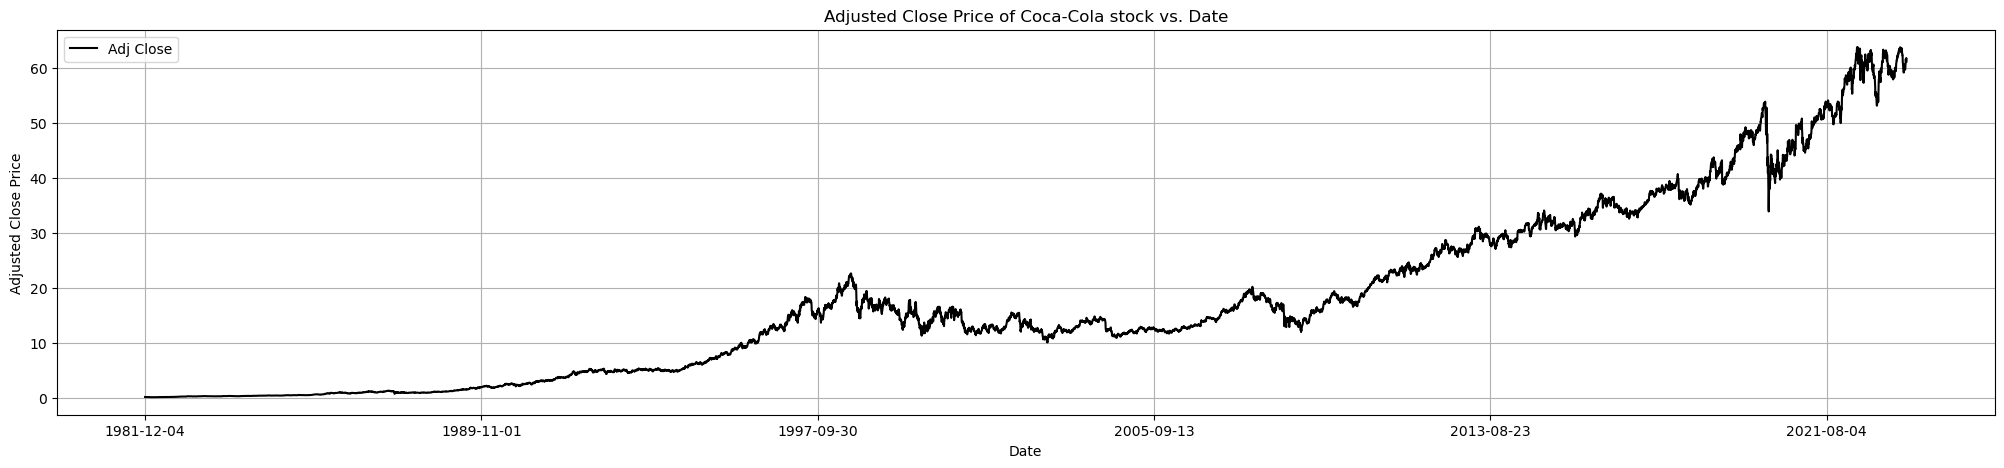

In [5]:
df_ko = yf.download(tickers="ko")
df_ko.to_csv("KO.csv")
df_ko = pd.read_csv("KO.csv")
df_ko = df_ko[5000:]
print(df_ko)
df_ko.plot(x="Date", y="Adj Close", kind="line", grid=True, color="black", figsize=(25, 5))  # Example for a line plot
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.title("Adjusted Close Price of Coca-Cola stock vs. Date")
plt.show()

In [6]:
data_df_avgd = df_ko[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].rolling(10).mean()
print(data_df_avgd)
# Drop all rows with NaN values
data_df_avgd.dropna(how='any', axis=0, inplace=True)
data_raw = data_df_avgd.to_numpy()
print(data_raw.shape)
num_data_points = data_raw.shape[0]

         Open    High     Low   Close  Adj Close      Volume
5000      NaN     NaN     NaN     NaN        NaN         NaN
5001      NaN     NaN     NaN     NaN        NaN         NaN
5002      NaN     NaN     NaN     NaN        NaN         NaN
5003      NaN     NaN     NaN     NaN        NaN         NaN
5004      NaN     NaN     NaN     NaN        NaN         NaN
...       ...     ...     ...     ...        ...         ...
15470  60.610  60.974  60.312  60.654  60.288448  15255800.0
15471  60.669  61.026  60.381  60.705  60.385365  15361420.0
15472  60.705  61.099  60.467  60.817  60.542949  15661940.0
15473  60.885  61.273  60.644  60.980  60.751465  15499490.0
15474  61.066  61.429  60.764  61.063  60.880095  16451260.0

[10475 rows x 6 columns]
(10466, 6)


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
scaler_model = scaler.fit(data_raw)
normalized_data = scaler_model.transform(data_raw)
mean = scaler.mean_[4]
scale = scaler.scale_[4]

mm_scaler = MinMaxScaler()
mm_scaler_model = mm_scaler.fit(data_raw)
normalized_data = mm_scaler_model.transform(data_raw)
min_val = mm_scaler.data_min_[4]
mm_scale = mm_scaler.scale_[4]

def inv_transform_aclosing(x: np.ndarray):
    return ((x*scale) + mean)

def inv_transform_minmax(x: np.ndarray):
    return ((x/mm_scale) + min_val)


In [8]:
def prepare_data_x(x: np.ndarray, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

def all_cols_to_matrices(data: np.ndarray, window_size):
    num_cols = data.shape[1]
    mat_x = []
    mat_x_unseen = []
    for i in range(num_cols):
        row = data[:,i].T
        row_x, row_x_unseen = prepare_data_x(row, window_size)
        mat_x.append(row_x)
        mat_x_unseen.append(row_x_unseen)
    return np.array(mat_x), np.array(mat_x_unseen)


data_x, data_x_unseen = all_cols_to_matrices(normalized_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data, window_size=config["data"]["window_size"])

data_x = np.moveaxis(data_x, 0, 2)

# Split dataset
split_index_train = int(data_y.shape[0] * config["data"]["train_split_size"])
split_index_val = int(data_y.shape[0] * config["data"]["val_split_size"]) + split_index_train


data_x_train = data_x[:split_index_train]
data_x_val =   data_x[split_index_train:split_index_val]
data_x_test =  data_x[split_index_val:]

data_y_train = data_y[:split_index_train]
data_y_val = data_y[split_index_train:split_index_val]
data_y_test = data_y[split_index_val:]


to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)
to_plot_data_y_test = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index_train+config["data"]["window_size"]] = mm_scaler.inverse_transform(data_y_train)[:, 4]
to_plot_data_y_val[split_index_train+config["data"]["window_size"]:split_index_val+config["data"]["window_size"]] = mm_scaler.inverse_transform(data_y_val)[:, 4]
to_plot_data_y_test[split_index_val+config["data"]["window_size"]:] = mm_scaler.inverse_transform(data_y_test)[:, 4]

In [9]:
print(data_x.shape)
print(data_x_val.shape)
print(normalized_data.shape)

(10402, 64, 6)
(1040, 64, 6)
(10466, 6)


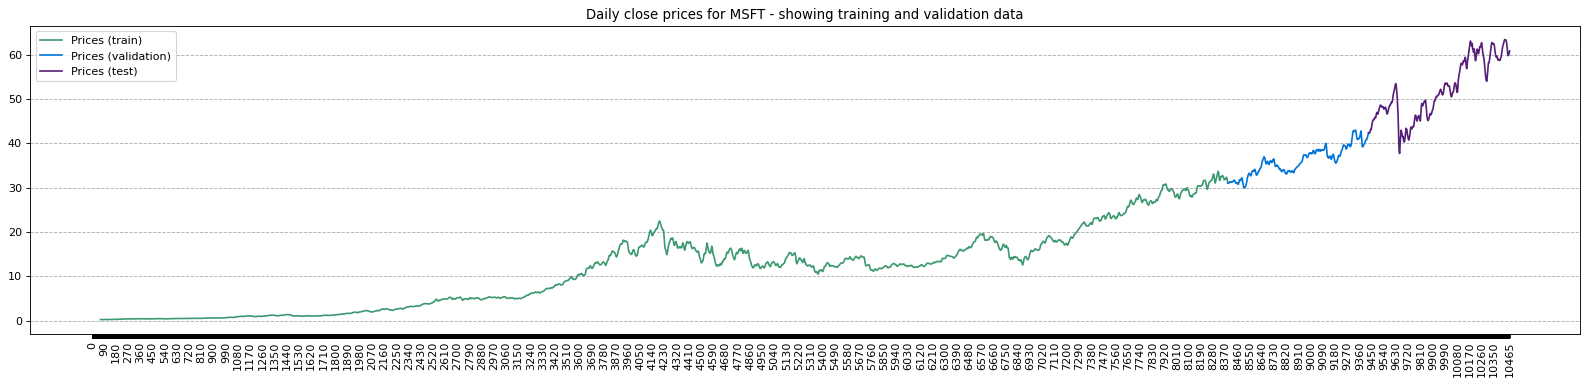

In [10]:
to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

## plots
data_date = np.arange(to_plot_data_y_train.shape[0])
fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
plt.plot(data_date, to_plot_data_y_test, label="Prices (test)", color=config["plots"]["color_test"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])


dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
dataset_test = TimeSeriesDataset(data_x_test, data_y_test)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)
print("Test data shape", dataset_test.x.shape, dataset_test.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (8321, 64, 6) (8321, 6)
Validation data shape (1040, 64, 6) (1040, 6)
Test data shape (1041, 64, 6) (1041, 6)


## Optuna Hyper Parameter Selection

In [12]:
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def define_model(trial):
    # Define RWKV model
    n_hidden_size = trial.suggest_int("n_hidden_size", 4, 32)  # Number of hiddens size will be in [4, 32] 
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 8, 32)
    n_context_length = trial.suggest_int("n_context", 20, 60)
    dropout = trial.suggest_float("dropout", 0.1, 0.3)

    rwkv_config = RwkvConfig(vocab_size=0, context_length=n_context_length, use_cache=False, hidden_size=n_hidden_size, num_hidden_layers=n_hidden_layers)
    rwkv_model = RwkvModel(rwkv_config, dropout=dropout)
    return rwkv_model


In [14]:
def objective(trial):
    model = define_model(trial).to(device)

    # Generate the optimizers.
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)  # log=True, will use log scale to interplolate between lr
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95) # To be suggested too

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    epochs = trial.suggest_int("epochs", 15, 20)

    # Dataloaders
    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        train_iterator = iter(train_dataloader)
        nb_batches_train = len(train_dataloader)
        train_acc = 0
        model.train()
        losses = 0.0

        for idx, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            out = out.last_hidden_state[:,-1,0]
            loss = criterion(out, y[:, 4].contiguous())

            optimizer.zero_grad()

            loss.backward()
            losses += loss.item()

            optimizer.step()


        data_iterator = iter(val_dataloader)
        nb_batches = len(val_dataloader)
        model.eval()
        acc = 0
        losses = 0.0
        for _, (x, y) in enumerate(data_iterator):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            out = out.last_hidden_state[:,-1,0]
            loss = criterion(out, y[:, 4].contiguous())
            losses += loss

        # Step scheduler
        scheduler.step()

        # Calc score and report to optuna
        score = losses / nb_batches
        trial.report(score, epoch)

        # then, Optuna can decide if the trial should be pruned
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return score

In [ ]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="predict-coca-cola", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=20)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-06-24 16:24:37,438] A new study created in memory with name: predict-coca-cola
[I 2023-06-24 16:52:00,377] Trial 0 finished with value: 0.01756586693227291 and parameters: {'n_hidden_size': 14, 'n_hidden_layers': 13, 'n_context': 38, 'dropout': 0.12662895914968447, 'lr': 0.01419681204335523, 'optimizer': 'RMSprop', 'batch_size': 128, 'epochs': 19}. Best is trial 0 with value: 0.01756586693227291.
[I 2023-06-24 17:08:36,147] Trial 1 finished with value: 0.034846432507038116 and parameters: {'n_hidden_size': 13, 'n_hidden_layers': 8, 'n_context': 44, 'dropout': 0.10421404792972858, 'lr': 0.024327855899963776, 'optimizer': 'RMSprop', 'batch_size': 128, 'epochs': 19}. Best is trial 0 with value: 0.01756586693227291.
[I 2023-06-24 17:56:40,967] Trial 2 finished with value: 0.01249897014349699 and parameters: {'n_hidden_size': 11, 'n_hidden_layers': 23, 'n_context': 29, 'dropout': 0.16731679260380575, 'lr': 0.007596735153900415, 'optimizer': 'SGD', 'batch_size': 128, 'epochs': 19}. B

In [1]:
optuna.visualization.plot_param_importances(study)

NameError: name 'optuna' is not defined

In [ ]:
optuna.visualization.plot_contour(study)